In [45]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import re
from biomart import BiomartServer
import io

In [3]:
#os.getcwd()

# Linux workstation
#data_path = '/home/db600/phd/data/'

# Laptop
data_path = 'C:\\Users\\dan\\Documents\\phd\\data\\'

os.listdir(data_path)

['biomart',
 'depmap',
 'missing_gene_names.csv',
 'pathway_commons',
 'reactome',
 'reactome_rows_to_drop.csv',
 'string']

In [4]:
os.listdir(data_path +'/reactome/')

['reactome.homo_sapiens.interactions.tab-delimited_downloaded_23_10_23.txt',
 'reactome_dropped_rows.csv',
 'reactome_ppi.csv',
 'test_dropped_rows.csv']

In [5]:
reactome = pd.read_csv(data_path + '/reactome/reactome.homo_sapiens.interactions.tab-delimited_downloaded_23_10_23.txt', sep="\t")
print(reactome.columns)
reactome.head()

Index(['# Interactor 1 uniprot id', 'Interactor 1 Ensembl gene id',
       'Interactor 1 Entrez Gene id', 'Interactor 2 uniprot id',
       'Interactor 2 Ensembl gene id', 'Interactor 2 Entrez Gene id',
       'Interaction type', 'Interaction context', 'Pubmed references'],
      dtype='object')


,# Interactor 1 uniprot id,Interactor 1 Ensembl gene id,Interactor 1 Entrez Gene id,Interactor 2 uniprot id,Interactor 2 Ensembl gene id,Interactor 2 Entrez Gene id,Interaction type,Interaction context,Pubmed references
0,uniprotkb:Q9Y287,ENSEMBL:ENST00000378549|ENSEMBL:ENSP0000036781...,-,uniprotkb:Q9Y287,ENSEMBL:ENST00000378549|ENSEMBL:ENSP0000036781...,-,physical association,reactome:R-HSA-976871,14690516|10391242
1,uniprotkb:P37840,ENSEMBL:ENST00000394989|ENSEMBL:ENST0000039498...,-,uniprotkb:P37840,ENSEMBL:ENST00000394989|ENSEMBL:ENST0000039498...,-,physical association,reactome:R-HSA-1247852,24243840
2,uniprotkb:P0DJI8,ENSEMBL:ENST00000356524|ENSEMBL:ENSG0000017343...,-,uniprotkb:P0DJI8,ENSEMBL:ENST00000356524|ENSEMBL:ENSG0000017343...,-,physical association,reactome:R-HSA-976898,19393650|103558
3,uniprotkb:P06727,ENSEMBL:ENSG00000110244|ENSEMBL:ENST0000035778...,-,uniprotkb:P06727,ENSEMBL:ENSG00000110244|ENSEMBL:ENST0000035778...,-,physical association,reactome:R-HSA-976889,15146166
4,uniprotkb:P01160,ENSEMBL:ENSG00000175206|ENSEMBL:ENSP0000036566...,-,uniprotkb:P01160,ENSEMBL:ENSG00000175206|ENSEMBL:ENSP0000036566...,-,physical association,reactome:R-HSA-976987,2142465|2945573


In [6]:
# Take a look at the interaction types listed
print(reactome['Interaction type'].unique())

['physical association' 'enzymatic reaction'
 'oxidoreductase activity electron transfer reaction'
 'dephosphorylation reaction' 'glycosylation reaction'
 'phospholipase reaction' 'isomerase reaction' 'cleavage reaction'
 'decarboxylation reaction' 'deacetylation reaction'
 'carboxylation reaction' 'acetylation reaction'
 'nucleoside triphosphatase reaction' 'deneddylation reaction'
 'deubiquitination reaction' 'gtpase reaction' 'atpase reaction'
 'demethylation reaction' 'sulfurtransfer reaction' 'amidation reaction'
 'de-ADP-ribosylation reaction' 'phosphopantetheinylation'
 'tyrosinylation']


In [7]:
# Get row count for number of edges in the dataset
len(reactome)

106142

In [8]:
# Function to extract ENSG followed by 11 digits
def extract_ENSG(text):
    return re.findall(r'ENSG\d{11}', text)

# Apply the function to each cell in the column and store the result in a new column
reactome['extracted_ENSG 1'] = reactome['Interactor 1 Ensembl gene id'].apply(extract_ENSG)
reactome['extracted_ENSG 2'] = reactome['Interactor 2 Ensembl gene id'].apply(extract_ENSG)

# See the two new columns
reactome[['extracted_ENSG 1', 'extracted_ENSG 2']]

,extracted_ENSG 1,extracted_ENSG 2
0,[ENSG00000136156],[ENSG00000136156]
1,[ENSG00000145335],[ENSG00000145335]
2,[ENSG00000173432],[ENSG00000173432]
3,[ENSG00000110244],[ENSG00000110244]
4,[ENSG00000175206],[ENSG00000175206]
...,...,...
106137,[ENSG00000043591],[]
106138,[ENSG00000043591],[]
106139,[ENSG00000188778],[]
106140,[ENSG00000188778],[]


In [9]:
# Filter out any self references
reactome = reactome[reactome['extracted_ENSG 1'] != reactome['extracted_ENSG 2']]
len(reactome)

96071

In [10]:
# Get rows where either of the extracted ENSG columns is just an empty list
rows_with_empty_list =  reactome[reactome['extracted_ENSG 1'].apply(lambda x: x == []) | reactome['extracted_ENSG 2'].apply(lambda x: x == [])] 
rows_with_empty_list
len(rows_with_empty_list)

31980

In [11]:
# Remove the rows with empty ENSG values from the main dataset
reactome_complete = reactome[~reactome.isin(rows_with_empty_list).all(axis=1)]

print(len(reactome_complete))
reactome_complete.head(1000)

64091


,# Interactor 1 uniprot id,Interactor 1 Ensembl gene id,Interactor 1 Entrez Gene id,Interactor 2 uniprot id,Interactor 2 Ensembl gene id,Interactor 2 Entrez Gene id,Interaction type,Interaction context,Pubmed references,extracted_ENSG 1,extracted_ENSG 2
39,uniprotkb:P08123,ENSEMBL:ENSG00000164692|ENSEMBL:ENST0000029726...,-,uniprotkb:P02452,ENSEMBL:ENSP00000225964|ENSEMBL:ENSG0000010882...,-,physical association,reactome:R-HSA-2428940,24243840,[ENSG00000164692],[ENSG00000108821]
41,uniprotkb:P08123,ENSEMBL:ENSG00000164692|ENSEMBL:ENST0000029726...,-,uniprotkb:P02452,ENSEMBL:ENSP00000225964|ENSEMBL:ENSG0000010882...,-,physical association,reactome:R-HSA-2428940,24243840,[ENSG00000164692],[ENSG00000108821]
45,uniprotkb:P08123,ENSEMBL:ENSG00000164692|ENSEMBL:ENST0000029726...,-,uniprotkb:P02452,ENSEMBL:ENSP00000225964|ENSEMBL:ENSG0000010882...,-,physical association,reactome:R-HSA-2428940,24243840,[ENSG00000164692],[ENSG00000108821]
47,uniprotkb:P08123,ENSEMBL:ENSG00000164692|ENSEMBL:ENST0000029726...,-,uniprotkb:P02452,ENSEMBL:ENSP00000225964|ENSEMBL:ENSG0000010882...,-,physical association,reactome:R-HSA-2428940,24243840,[ENSG00000164692],[ENSG00000108821]
49,uniprotkb:P08123,ENSEMBL:ENSG00000164692|ENSEMBL:ENST0000029726...,-,uniprotkb:P02452,ENSEMBL:ENSP00000225964|ENSEMBL:ENSG0000010882...,-,physical association,reactome:R-HSA-2428940,24243840,[ENSG00000164692],[ENSG00000108821]
...,...,...,...,...,...,...,...,...,...,...,...
1573,uniprotkb:Q86YM7,ENSEMBL:ENSP00000426651|ENSEMBL:ENSG0000015241...,-,uniprotkb:Q13255,ENSEMBL:ENST00000507907|ENSEMBL:ENST0000049280...,-,physical association,reactome:R-HSA-6794288,9808458|9069287,[ENSG00000152413],[ENSG00000152822]
1574,uniprotkb:Q86YM7,ENSEMBL:ENSP00000426651|ENSEMBL:ENSG0000015241...,-,uniprotkb:P41594,ENSEMBL:ENST00000305447|ENSEMBL:ENSG0000016895...,-,physical association,reactome:R-HSA-6794288,9808458|9069287,[ENSG00000152413],[ENSG00000168959]
1575,uniprotkb:Q9NSB8,ENSEMBL:ENST00000304231|ENSEMBL:ENSP0000040763...,-,uniprotkb:P41594,ENSEMBL:ENST00000305447|ENSEMBL:ENSG0000016895...,-,physical association,reactome:R-HSA-6794288,9808458|9069287,[ENSG00000103942],[ENSG00000168959]
1576,uniprotkb:Q8N4T8,ENSEMBL:ENST00000306193|ENSEMBL:ENSG0000014543...,-,uniprotkb:Q92506,ENSEMBL:ENSP00000406488|ENSEMBL:ENST0000037466...,-,physical association,reactome:R-HSA-8862181,24243840,[ENSG00000145439],"[ENSG00000232357, ENSG00000228357, ENSG0000022..."


In [12]:
# See how many rows where either column1 or column2 contains a list with more than one item
len(reactome_complete[reactome_complete['extracted_ENSG 1'].apply(lambda x: isinstance(x, list) and len(x) > 1) |
                   reactome_complete['extracted_ENSG 2'].apply(lambda x: isinstance(x, list) and len(x) > 1)])

6849

In [13]:
import pandas as pd
from itertools import product

def expand_list_pairs(df, col1, col2, dropped_rows_csv_path):
    # Create a new DataFrame to hold the expanded rows
    expanded_rows = pd.DataFrame(columns=df.columns)

    # Track indices to drop from the original DataFrame
    indices_to_drop = []

    # Iterate through the DataFrame
    for idx, row in df.iterrows():
        # Check if either column has a list with more than one item
        is_col1_list = isinstance(row[col1], list) and len(row[col1]) > 1
        is_col2_list = isinstance(row[col2], list) and len(row[col2]) > 1

        if is_col1_list or is_col2_list:
            # Add index to the list of indices to drop
            indices_to_drop.append(idx)

            # Create combinations of items
            items_col1 = row[col1] if is_col1_list else [row[col1]]
            items_col2 = row[col2] if is_col2_list else [row[col2]]

            for combination in product(items_col1, items_col2):
                new_row = row.copy()
                new_row[col1] = combination[0]
                new_row[col2] = combination[1]
                # Append new_row to expanded_rows using concat
                expanded_rows = pd.concat([expanded_rows, pd.DataFrame([new_row])], ignore_index=True)

    # Extract the rows to be dropped into a separate DataFrame
    rows_to_drop = df.loc[indices_to_drop]

    # Save the rows to be dropped to a CSV file
    rows_to_drop.to_csv(dropped_rows_csv_path, index=False)

    # Drop the original rows where lists had more than one item
    df = df.drop(indices_to_drop)

    # Concatenate the original DataFrame with the expanded rows
    df = pd.concat([df, expanded_rows], ignore_index=True)

    return df

In [14]:
data = {
    'column1': [[1, 2], [3], ['l'], ['a', 'b', 'c'], [5]],
    'column2': [[2], [1, 2], ['x', 'y'], [6], ['a']]
}
df1 = pd.DataFrame(data)

In [15]:
df_revised = expand_list_pairs(df1, 'column1', 'column2', data_path + '/reactome/test_dropped_rows.csv')

In [16]:
print(df1)
print(df_revised)

     column1 column2
0     [1, 2]     [2]
1        [3]  [1, 2]
2        [l]  [x, y]
3  [a, b, c]     [6]
4        [5]     [a]
  column1 column2
0     [5]     [a]
1       1     [2]
2       2     [2]
3     [3]       1
4     [3]       2
5     [l]       x
6     [l]       y
7       a     [6]
8       b     [6]
9       c     [6]


In [17]:
#reactome_final = expand_list_pairs(reactome_complete, 'extracted_ENSG 1', 'extracted_ENSG 2')
reactome_final = expand_list_pairs(reactome_complete, 'extracted_ENSG 1', 'extracted_ENSG 2', data_path + '/reactome/reactome_dropped_rows.csv')

In [18]:
multiple_genes_listed = reactome_final[reactome_final['extracted_ENSG 1'].apply(lambda x: isinstance(x, list) and len(x) > 1) |
                   reactome_final['extracted_ENSG 2'].apply(lambda x: isinstance(x, list) and len(x) > 1)]

multiple_genes_listed

,# Interactor 1 uniprot id,Interactor 1 Ensembl gene id,Interactor 1 Entrez Gene id,Interactor 2 uniprot id,Interactor 2 Ensembl gene id,Interactor 2 Entrez Gene id,Interaction type,Interaction context,Pubmed references,extracted_ENSG 1,extracted_ENSG 2


In [19]:
print(len(reactome_final))
reactome_final.head(1000)

103760


,# Interactor 1 uniprot id,Interactor 1 Ensembl gene id,Interactor 1 Entrez Gene id,Interactor 2 uniprot id,Interactor 2 Ensembl gene id,Interactor 2 Entrez Gene id,Interaction type,Interaction context,Pubmed references,extracted_ENSG 1,extracted_ENSG 2
0,uniprotkb:P08123,ENSEMBL:ENSG00000164692|ENSEMBL:ENST0000029726...,-,uniprotkb:P02452,ENSEMBL:ENSP00000225964|ENSEMBL:ENSG0000010882...,-,physical association,reactome:R-HSA-2428940,24243840,[ENSG00000164692],[ENSG00000108821]
1,uniprotkb:P08123,ENSEMBL:ENSG00000164692|ENSEMBL:ENST0000029726...,-,uniprotkb:P02452,ENSEMBL:ENSP00000225964|ENSEMBL:ENSG0000010882...,-,physical association,reactome:R-HSA-2428940,24243840,[ENSG00000164692],[ENSG00000108821]
2,uniprotkb:P08123,ENSEMBL:ENSG00000164692|ENSEMBL:ENST0000029726...,-,uniprotkb:P02452,ENSEMBL:ENSP00000225964|ENSEMBL:ENSG0000010882...,-,physical association,reactome:R-HSA-2428940,24243840,[ENSG00000164692],[ENSG00000108821]
3,uniprotkb:P08123,ENSEMBL:ENSG00000164692|ENSEMBL:ENST0000029726...,-,uniprotkb:P02452,ENSEMBL:ENSP00000225964|ENSEMBL:ENSG0000010882...,-,physical association,reactome:R-HSA-2428940,24243840,[ENSG00000164692],[ENSG00000108821]
4,uniprotkb:P08123,ENSEMBL:ENSG00000164692|ENSEMBL:ENST0000029726...,-,uniprotkb:P02452,ENSEMBL:ENSP00000225964|ENSEMBL:ENSG0000010882...,-,physical association,reactome:R-HSA-2428940,24243840,[ENSG00000164692],[ENSG00000108821]
...,...,...,...,...,...,...,...,...,...,...,...
995,uniprotkb:P46098,ENSEMBL:ENSP00000347754|ENSEMBL:ENSP0000042477...,-,uniprotkb:Q70Z44,ENSEMBL:ENST00000428798|ENSEMBL:ENSP0000038926...,-,physical association,reactome:R-HSA-6792753,24243840,[ENSG00000166736],[ENSG00000186090]
996,uniprotkb:P46098,ENSEMBL:ENSP00000347754|ENSEMBL:ENSP0000042477...,-,uniprotkb:A5X5Y0,ENSEMBL:ENST00000425359|ENSEMBL:ENSG0000018603...,-,physical association,reactome:R-HSA-6792754,24243840,[ENSG00000166736],[ENSG00000186038]
997,uniprotkb:P01877,ENSEMBL:ENSG00000211890|ENSEMBL:ENSP0000037498...,-,uniprotkb:P01591,ENSEMBL:ENSP00000254801|ENSEMBL:ENSP0000042668...,-,physical association,reactome:R-HSA-8858031,11877257,[ENSG00000211890],[ENSG00000132465]
998,uniprotkb:Q8IVH4,ENSEMBL:ENSP00000497680|ENSEMBL:ENSP0000049700...,-,uniprotkb:P22033,ENSEMBL:ENST00000274813|ENSEMBL:ENSG0000014608...,-,physical association,reactome:R-HSA-5654974,24243840,[ENSG00000151611],[ENSG00000146085]


In [20]:
# Convert list columns to strings
reactome_final['extracted_ENSG 1'] = reactome_final['extracted_ENSG 1'].apply(str)
reactome_final['extracted_ENSG 2'] = reactome_final['extracted_ENSG 2'].apply(str)

# Now select only the columns we want and drop duplicates
reactome_ppi = reactome_final[['extracted_ENSG 1', 'extracted_ENSG 2']] 
reactome_ppi = reactome_ppi.drop_duplicates()

# Print length and head
print(len(reactome_ppi))
print(reactome_ppi.head(10))

37951
       extracted_ENSG 1     extracted_ENSG 2
0   ['ENSG00000164692']  ['ENSG00000108821']
18  ['ENSG00000108821']  ['ENSG00000164692']
72  ['ENSG00000108947']  ['ENSG00000090776']
73  ['ENSG00000125266']  ['ENSG00000108947']
74  ['ENSG00000125266']  ['ENSG00000090776']
75  ['ENSG00000184009']  ['ENSG00000075624']
76  ['ENSG00000149534']  ['ENSG00000179639']
77  ['ENSG00000149534']  ['ENSG00000158869']
78  ['ENSG00000158869']  ['ENSG00000179639']
79  ['ENSG00000186393']  ['ENSG00000204897']


37951
37951
75902


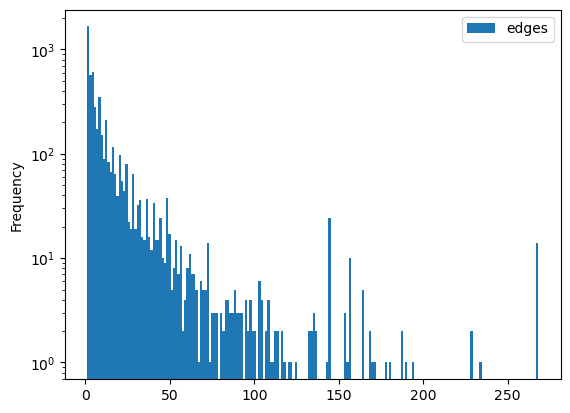

In [21]:
# Get number of nodes and edges and plot histogram of edges showing number of nodes with X edges 
total_gene_a = reactome_ppi['extracted_ENSG 1'].tolist()
total_gene_b = reactome_ppi['extracted_ENSG 2'].tolist()
total_gene = total_gene_a + total_gene_b

total_gene_df = pd.DataFrame(total_gene, columns=['gene'])

total_gene_df['edges'] = total_gene_df['gene'].map(total_gene_df['gene'].value_counts())

print(len(total_gene_a))
print(len(total_gene_b))
print(len(total_gene))

total_gene_df.head()

unique_gene_df = total_gene_df.drop_duplicates('gene') 
unique_gene_df.sort_values(by='edges', ascending=False)

fig = unique_gene_df.plot(kind='hist', bins=200)

plt.yscale('log')
plt.show()

In [22]:
# See how many unique nodes there are in total
unique_gene_a = reactome_ppi['extracted_ENSG 1'].unique().tolist()
unique_gene_b = reactome_ppi['extracted_ENSG 2'].unique().tolist()
unique_gene_all = set(unique_gene_a + unique_gene_b)

print(len(unique_gene_a))
print(len(unique_gene_b))
print(len(unique_gene_all))

#df = pd.DataFrame.from_dict(count, orient='index')
#df.plot(kind='bar')

4277
4263
5478


In [23]:
reactome_ppi.columns = ['gene1', 'gene2']
reactome_ppi.head()

,gene1,gene2
0,['ENSG00000164692'],['ENSG00000108821']
18,['ENSG00000108821'],['ENSG00000164692']
72,['ENSG00000108947'],['ENSG00000090776']
73,['ENSG00000125266'],['ENSG00000108947']
74,['ENSG00000125266'],['ENSG00000090776']


In [24]:
reactome_ppi['gene1'] = reactome_ppi['gene1'].str.replace("\['", "", regex=True).str.replace("']", "", regex=True)
reactome_ppi['gene2'] = reactome_ppi['gene2'].str.replace("\['", "", regex=True).str.replace("']", "", regex=True)

reactome_ppi.head()

,gene1,gene2
0,ENSG00000164692,ENSG00000108821
18,ENSG00000108821,ENSG00000164692
72,ENSG00000108947,ENSG00000090776
73,ENSG00000125266,ENSG00000108947
74,ENSG00000125266,ENSG00000090776


In [25]:
reactome_ppi.to_csv(data_path + '/reactome/reactome_ppi.csv', index=False)

In [26]:
gene_converter = pd.read_csv(data_path + '/biomart/gene_multi_converter.csv')

In [27]:
gene_converter.head()

,Unnamed: 0,Entrez gene ID,Fasta,Gene name,Gene stable ID,Protein stable ID,RefSeq peptide ID,Transcript stable ID,UniProtKB/Swiss-Prot ID,UniProtKB/TrEMBL ID
0,0,4535,MPMANLLLLIVPILIAMAFLMLTERKILGYMQLRKGPNVVGPYGLL...,MT-ND1,ENSG00000198888,ENSP00000354687,YP_003024026,ENST00000361390,P03886,U5Z754
1,1,4536,INPLAQPVIYSTIFAGTLITALSSHWFFTWVGLEMNMLAFIPVLTK...,MT-ND2,ENSG00000198763,ENSP00000355046,YP_003024027,ENST00000361453,P03891,Q7GXY9
2,2,4512,MFADRWLFSTNHKDIGTLYLLFGAWAGVLGTALSLLIRAELGQPGN...,MT-CO1,ENSG00000198804,ENSP00000354499,YP_003024028,ENST00000361624,P00395,U5YWV7
3,3,4513,MAHAAQVGLQDATSPIMEELITFHDHALMIIFLICFLVLYALFLTL...,MT-CO2,ENSG00000198712,ENSP00000354876,YP_003024029,ENST00000361739,P00403,U5Z487
4,4,4509,MPQLNTTVWPTMITPMLLTLFLITQLKMLNTNYHLPPSPKPMKMKN...,MT-ATP8,ENSG00000228253,ENSP00000355265,YP_003024030,ENST00000361851,P03928,U5YV54


In [28]:
len(gene_converter[gene_converter['Gene stable ID'].isin(unique_gene_all)])

3678

In [33]:
#Connect to a Biomart Server
server = BiomartServer("http://useast.ensembl.org/biomart")

# set verbose to True to get some messages
server.verbose = True

# use the 'hsapiens_gene_ensembl' dataset
hsapiens_gene_ensembl = server.datasets['hsapiens_gene_ensembl']

# show all available filters and attributes of the 'hsapiens_gene_ensembl' dataset
#hsapiens_gene_ensembl.show_filters()  # uses pprint
hsapiens_gene_ensembl.show_attributes()  # uses print

[BiomartServer:'http://useast.ensembl.org/biomart/martservice'] Fetching datasets
[BiomartServer:'http://useast.ensembl.org/biomart/martservice'] Fetching databases
[BiomartDatabase:'Ensembl Genes 110'] Fetching datasets
[BiomartDatabase:'Mouse strains 110'] Fetching datasets
[BiomartDatabase:'Sequence'] Fetching datasets
[BiomartDatabase:'Ontology'] Fetching datasets
[BiomartDatabase:'Genomic features 110'] Fetching datasets
[BiomartDatabase:'Ensembl Variation 110'] Fetching datasets
[BiomartDatabase:'Ensembl Regulation 110'] Fetching datasets
[BiomartDataset:'hsapiens_gene_ensembl'] Fetching attributes
{'3_utr_end': '3' UTR end' (default: False),
 '3_utr_start': '3' UTR start' (default: False),
 '3utr': '3' UTR' (default: False),
 '5_utr_end': '5' UTR end' (default: False),
 '5_utr_start': '5' UTR start' (default: False),
 '5utr': '5' UTR' (default: False),
 'abrachyrhynchus_homolog_associated_gene_name': 'Pink-footed goose gene name' (default: False),
 'abrachyrhynchus_homolog_canon

In [48]:
# run a search with custom filters and attributes (no header)
response = hsapiens_gene_ensembl.search({
  #'filters': {
  #    'ensembl_gene_id': unique_gene_all,
  #},
  'attributes': [
      'ensembl_gene_id', 'hgnc_symbol', 'chromosome_name', 'ensembl_transcript_id', 'ensembl_peptide_id', 'uniprotsptrembl', 'uniprotswissprot'
  ]
}, header = 1)

# i = -1
# #response format is TSV
# for line in response.iter_lines():
#   i+=1
#   line = line.decode('utf-8')
#   #print(line.split("\t"))
#   conv_frame.loc[i] = line.split("\t")

if response.ok:
    # Convert the response content to a file-like object
    content = io.StringIO(response.content.decode('utf-8'))

    # Read the content into a DataFrame
    conv_frame = pd.read_csv(content, sep='\t')
else:
    print("Error with the response")
    

[BiomartDataset:'hsapiens_gene_ensembl'] Searching using following params:
{'attributes': ['ensembl_gene_id',
                'hgnc_symbol',
                'chromosome_name',
                'ensembl_transcript_id',
                'ensembl_peptide_id',
                'uniprotsptrembl',
                'uniprotswissprot']}
[BiomartDataset:'hsapiens_gene_ensembl'] Fetching attributes
[BiomartDataset] search query:
b'<Query virtualSchemaName="default" formatter="TSV" header="1" uniqueRows="1" datasetConfigVersion="0.6" count=""><Dataset name="hsapiens_gene_ensembl" interface="default"><Attribute name="ensembl_gene_id" /><Attribute name="hgnc_symbol" /><Attribute name="chromosome_name" /><Attribute name="ensembl_transcript_id" /><Attribute name="ensembl_peptide_id" /><Attribute name="uniprotsptrembl" /><Attribute name="uniprotswissprot" /></Dataset></Query>'


In [49]:
conv_frame.head()

,Gene stable ID,HGNC symbol,Chromosome/scaffold name,Transcript stable ID,Protein stable ID,UniProtKB/TrEMBL ID,UniProtKB/Swiss-Prot ID
0,ENSG00000198888,MT-ND1,MT,ENST00000361390,ENSP00000354687,U5Z754,P03886
1,ENSG00000198763,MT-ND2,MT,ENST00000361453,ENSP00000355046,Q7GXY9,P03891
2,ENSG00000198804,MT-CO1,MT,ENST00000361624,ENSP00000354499,U5YWV7,P00395
3,ENSG00000198712,MT-CO2,MT,ENST00000361739,ENSP00000354876,U5Z487,P00403
4,ENSG00000228253,MT-ATP8,MT,ENST00000361851,ENSP00000355265,U5YV54,P03928


In [50]:
len(conv_frame)

123120

In [51]:
len(conv_frame[conv_frame['Gene stable ID'].isin(unique_gene_all)])

4095